In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [ ]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-04-30 02:18:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.199.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-04-30 02:18:33 (110 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [ ]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                        bias_regularizer=regularizers.l2(1e-4),
                                        activity_regularizer=regularizers.l2(1e-5)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 256)           822016    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 10, 256)           394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_3 (Dense)              (None, 1605)              207045    
_________________________________________________________________
dense_4 (Dense)              (None, 3211)              5156866   
Total params: 6,744,519
Trainable params: 6,744,519
Non-trainable params: 0
____________________________________________

In [ ]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 13s 17ms/step - loss: 7.0243 - accuracy: 0.0185
Epoch 2/100
484/484 [==============================] - 8s 17ms/step - loss: 6.4643 - accuracy: 0.0263
Epoch 3/100
484/484 [==============================] - 8s 17ms/step - loss: 6.2748 - accuracy: 0.0370
Epoch 4/100
484/484 [==============================] - 8s 18ms/step - loss: 6.0357 - accuracy: 0.0426
Epoch 5/100
484/484 [==============================] - 8s 17ms/step - loss: 5.8037 - accuracy: 0.0492
Epoch 6/100
484/484 [==============================] - 8s 17ms/step - loss: 5.5839 - accuracy: 0.0634
Epoch 7/100
484/484 [==============================] - 8s 17ms/step - loss: 5.3334 - accuracy: 0.0754
Epoch 8/100
484/484 [==============================] - 8s 17ms/step - loss: 5.1071 - accuracy: 0.0912
Epoch 9/100
484/484 [==============================] - 8s 17ms/step - loss: 4.8631 - accuracy: 0.1064
Epoch 10/100
484/484 [==============================] - 8s 17ms/step - loss: 4.61

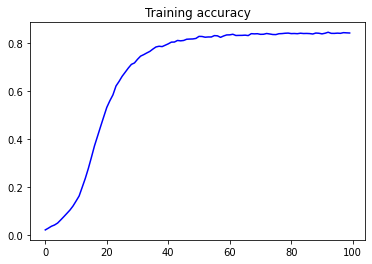

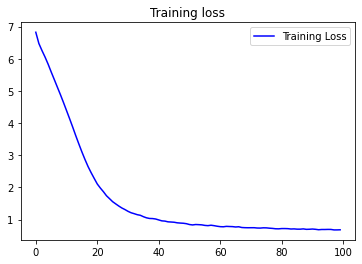

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope my content abuse me hate forth me seen gone are that my muse love torn torn thence it in torn seen brow ' mad with dost dost hate it seen hate groan hate forth green me so fair old ' have mine for me in it bright wrong directed seen wrong days seen seen war repair ' on you are tell my mind alone are free it hits free green thee not not still green my ill say awake me not so fair belong it ' are so bold not that free free gone more ' seen green me truth
